The scheme to implement a model with keras:

* Architecture of the model
* Compiling the model
* Training of the model Diagnosis of the training
* Evaluation of predictions

In [162]:
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import os
import matplotlib.cm as cm
import random
import seaborn as sns

%matplotlib inline

* loading and preprocessing the dataset

In [163]:
dataset_path = '../../words'  # Update the path as necessary
data = []
words = open("../ascii/words.txt", "r").readlines()
inexistent_or_corrupted= 0

for line in tqdm(words):
    if line.startswith("#"):
        continue
    parts = line.strip().split()
    fixed_part = parts[:8]
    transcription_part = ' '.join(parts[8:])

    line_split = line.split(" ")
    folder_parts = line_split[0].split('-')
    folder1 = folder_parts[0]
    folder2 = folder_parts[0] + '-' + folder_parts[1]
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip('\n')
    rel_path = os.path.join(dataset_path, folder1, folder2, file_name)

    if os.path.exists(rel_path) and os.path.getsize(rel_path) > 0:
        data.append(fixed_part + [transcription_part, rel_path])
    else:
        inexistent_or_corrupted += 1

print('inexistent_or_corrupted', inexistent_or_corrupted)
df = pd.DataFrame(data, columns=['line_id', 'result', 'graylevel', 'x', 'y', 'w', 'h', 'annotation', 'transcription', 'image_path'])
display(df.head())

100%|██████████| 115338/115338 [00:10<00:00, 11377.43it/s]


inexistent_or_corrupted 2


,line_id,result,graylevel,x,y,w,h,annotation,transcription,image_path
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,../../words\a01\a01-000u\a01-000u-00-00.png
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,../../words\a01\a01-000u\a01-000u-00-01.png
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,../../words\a01\a01-000u\a01-000u-00-02.png
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,../../words\a01\a01-000u\a01-000u-00-03.png
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,../../words\a01\a01-000u\a01-000u-00-04.png


* check transcription distribution and remove transcriptions with fewer than 2 samples 

In [164]:
# Check transcription distribution
print("Transcription distribution before filtering:")
print(df['transcription'].value_counts())

# Remove transcription with fewer than 2 samples
min_samples = 2
class_counts = df['transcription'].value_counts()
classes_to_keep = class_counts[class_counts >= min_samples].index
df_filtered = df[df['transcription'].isin(classes_to_keep)].copy()
# reset index after manipulation
df_filtered.reset_index(drop=True, inplace=True)

# Check transcription distribution after filtering
print("Transcription distribution after filtering:")
print(df_filtered['transcription'].value_counts())

le = LabelEncoder()
df_filtered['transcription_encoded'] = None
df_filtered['transcription_encoded'] = le.fit_transform(df_filtered['transcription'])

display(df_filtered.info())
display(df_filtered.head())

Transcription distribution before filtering:
transcription
the           5826
,             5570
.             4984
of            3192
to            2651
              ... 
dimensions       1
painting         1
cutters          1
Parana           1
hullo            1
Name: count, Length: 13550, dtype: int64
Transcription distribution after filtering:
transcription
the          5826
,            5570
.            4984
of           3192
to           2651
             ... 
specified       2
palm            2
smoothing       2
gate            2
doorman         2
Name: count, Length: 6360, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108128 entries, 0 to 108127
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   line_id                108128 non-null  object
 1   result                 108128 non-null  object
 2   graylevel              108128 non-null  object
 3   x                  

None

,line_id,result,graylevel,x,y,w,h,annotation,transcription,image_path,transcription_encoded
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,../../words\a01\a01-000u\a01-000u-00-00.png,116
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,../../words\a01\a01-000u\a01-000u-00-01.png,850
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,../../words\a01\a01-000u\a01-000u-00-02.png,5884
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,../../words\a01\a01-000u\a01-000u-00-03.png,5573
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,../../words\a01\a01-000u\a01-000u-00-04.png,930


* preparing image data

In [165]:
X = []
y = []

# Use tqdm to add a progress bar
for index, row in tqdm(df_filtered.iterrows(), total=df_filtered.shape[0], desc="Processing Images"):
    # Save only images in X and transcription in Y, using cv2.imread to read the image without resizing or normalizing
    image = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
    if image is not None:
        X.append(image)
        y.append(row['transcription_encoded'])
    else:
        print(f"Warning: Image at path {row['image_path']} could not be read.")

print('X and Y have the same length:', len(X) == len(y))

Processing Images: 100%|██████████| 108128/108128 [05:11<00:00, 347.63it/s]

X and Y have the same length: True


* Train and testing split (80/20)

In [166]:
# X contains elements of varying shapes or sizes, meaning that not all images have the same dimensions, 
# we need to convert all element of X into a uniform dimension in order to ba able to convert them into Numpy array array
X_resized = []

for img in X:
    # If the image is not 28x28, resize it
    if img.shape != (28, 28):
        img = cv2.resize(img, (28, 28))
    X_resized.append(img)

# Convert to NumPy array after resizing
X = np.array(X_resized)
y = np.array(y)
print('Shape of X:',X.shape)
print('Shape of y:',y.shape)

Shape of X: (108128, 28, 28)
Shape of y: (108128,)


In [167]:
#splitting the dataset into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


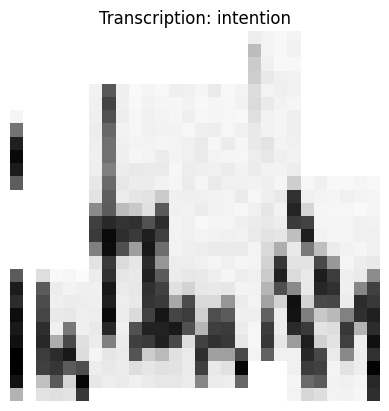

In [168]:
#Display a random image from the dataset

random_index = random.randint(0, len(X) - 1)
plt.imshow(X[random_index], cmap='gray')
plt.title(f"Transcription: {df_filtered['transcription'][random_index]}")
plt.axis('off')  # Hide axes for better visualization
plt.show()

* transforming data into 4-dimensional array (images, width, height, depth)
* One-hot encoding for labels

In [169]:
# Changing the shape of X_train and X_test
X_train = X_train.reshape([-1, 28*28])
X_test = X_test.reshape([-1, 28*28])

print('Shape of X:',X_train.shape)
print('Shape of y:',y_train.shape)

# Transform the X_train and X_test data into a 4 dimensional array (nb_images, width, height, depth)
X_train = X_train.reshape((-1,28,28,1))

print('Shape of X:',X_train.shape)
print('Shape of y:',y_train.shape)

# Normalization of X_train and X_test
X_train = X_train/255
X_test = X_test/255

#Transform the labels of y_train and y_test into binary categorical vectors (one hot)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Shape of X: (86502, 784)
Shape of y: (86502,)
Shape of X: (86502, 28, 28, 1)
Shape of y: (86502,)


In [170]:
#Instantiate an input layer taking as argument shape = (28,28,1)
inputs = Input(shape = (28, 28,1), name = "Input")

# Instantiate a convolution layer called first_layer using the Conv2D constructor
first_layer = Conv2D(filters = 32,  #The layer will be composed of 32 convolution matrices.
                     kernel_size = (5, 5), #the convolution kernel will be of dimension 5x5 (25 neurons per filter).
                     padding = 'valid', #so that the kernel cannot exceed the edges of the image.  
                     activation = 'relu')

second_layer = MaxPooling2D(pool_size = (2, 2)) # Instantiate a max-pooling layer called second_layer using the MaxPooling2D constructor with the parameter pool_size = (2, 2) so that the maximum is computed on 2x2 size pieces.


# Add the layers to the model
x=first_layer(inputs)
x=second_layer(x)

In [171]:
# Instantiate a dropout layer called third_layer using the Dropout constructor with the rate = 0.2 parameter to cut off 20% of the connections between the previous and next layers.
third_layer = Dropout(rate = 0.2)
#  Instantiate a flattening layer called fourth_layer using the Flatten constructor. This layer does not take any parameters and just flattens a matrix into a vector. This transformation is necessary for the following because dense layers only take vectors as input and not matrices.
fourth_layer = Flatten()
#  Instantiate a dense layer called fifth_layer using the Dense constructor with 128 neurons and the ReLU activation function.
fifth_layer = Dense(units = 128,
                    activation = 'relu')
output_layer = Dense(units = 6360,
                     activation='softmax')
# Add all new layers to the model
x=third_layer(x)
x=fourth_layer(x)
x=fifth_layer(x)
outputs=output_layer(x)

# Create the Model
model = Model(inputs = inputs, outputs = outputs)

In [172]:
#Compile the model using the 'categorical_crossentropy' loss function, the 'adam' gradient descent algorithm as optimizer', and the **['accuracy']`** metric.
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

#Train the model with the training data on 10 epochs, batches of size 400 and a test split of 0.2. Store the training output in a variable named training_history.
training_history = model.fit(X_train,y_train,validation_split=0.2,epochs=10,batch_size=400)

Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.0734 - loss: 7.0678 - val_accuracy: 0.1588 - val_loss: 5.9080
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.1841 - loss: 5.6824 - val_accuracy: 0.2318 - val_loss: 5.7138
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.2379 - loss: 5.1641 - val_accuracy: 0.2780 - val_loss: 4.9611
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.2804 - loss: 4.6589 - val_accuracy: 0.2820 - val_loss: 4.9592
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.2980 - loss: 4.3872 - val_accuracy: 0.3008 - val_loss: 4.8857
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.3327 - loss: 4.0419 - val_accuracy: 0.3553 - val_loss: 4.2189
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.3597 - loss: 3.7032 - val_accuracy: 0.3618 - val_loss: 4.1653
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.3866 - loss: 3.4055 - 

Test the effect of adding more dense layers

In [173]:
# Instantiate a dropout layer called third_layer using the Dropout constructor with the rate = 0.2 parameter to cut off 20% of the connections between the previous and next layers.
third_layer = Dropout(rate = 0.2)
#  Instantiate a flattening layer called fourth_layer using the Flatten constructor. This layer does not take any parameters and just flattens a matrix into a vector. This transformation is necessary for the following because dense layers only take vectors as input and not matrices.
fourth_layer = Flatten()
#  Instantiate a dense layer called fifth_layer using the Dense constructor with 128 neurons and the ReLU activation function.
fifth_layer = Dense(units = 128,
                    activation = 'relu')
#  Instantiate a dense layer called fifth_layer using the Dense constructor with 128 neurons and the ReLU activation function.
sixth_layer = Dense(units = 2000,
                    activation = 'relu')
#  Instantiate a dense layer called fifth_layer using the Dense constructor with 128 neurons and the ReLU activation function.
seventh_layer = Dense(units = 12000,
                    activation = 'relu')
#  Instantiate a dense layer called output_layer with 10 neurons (for 10 output classes) and an activation function softmax to return probability predictions for each class.
output_layer = Dense(units = 6360,
                     activation='softmax')
# Add all new layers to the model
x=third_layer(x)
x=fourth_layer(x)
x=fifth_layer(x)
x=sixth_layer(x)
x=seventh_layer(x)
outputs=output_layer(x)


# Create the Model
model = Model(inputs = inputs, outputs = outputs)

In [174]:
#Compile the model using the 'categorical_crossentropy' loss function, the 'adam' gradient descent algorithm as optimizer', and the **['accuracy']`** metric.
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

#Train the model with the training data on 10 epochs, batches of size 400 and a test split of 0.2. Store the training output in a variable named training_history.
training_history = model.fit(X_train,y_train,validation_split=0.2,epochs=20,batch_size=400)

Epoch 1/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.1513 - loss: 6.6260 - val_accuracy: 0.3500 - val_loss: 4.3048
Epoch 2/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 468s 3s/step - accuracy: 0.3239 - loss: 4.1448 - val_accuracy: 0.3752 - val_loss: 3.9914
Epoch 3/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.3494 - loss: 3.6506 - val_accuracy: 0.4090 - val_loss: 3.6762
Epoch 4/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.3862 - loss: 3.1952 - val_accuracy: 0.4130 - val_loss: 3.6674
Epoch 5/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.3946 - loss: 3.0009 - val_accuracy: 0.4107 - val_loss: 3.8224
Epoch 6/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 573s 3s/step - accuracy: 0.4151 - loss: 2.7640 - val_accuracy: 0.3914 - val_loss: 3.8974
Epoch 7/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 567s 3s/step - accuracy: 0.4259 - loss: 2.6454 - val_accuracy: 0.4390 - val_loss: 3.7816
Epoch 8/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 577s 3s/step - accuracy: 0.4510 - loss: 2.4294 - val_accu

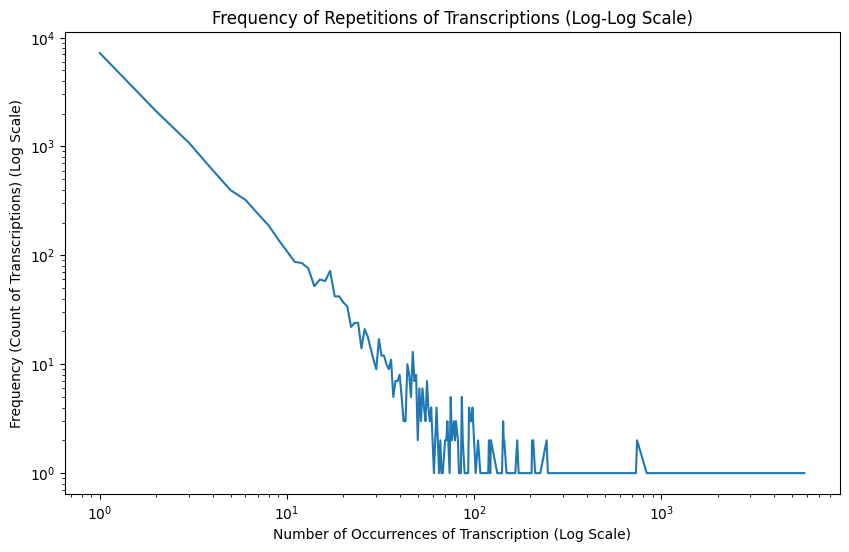

In [175]:
transcription_counts = df['transcription'].value_counts()
frequency_counts = transcription_counts.value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x=frequency_counts.index, y=frequency_counts.values)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Occurrences of Transcription (Log Scale)')
plt.ylabel('Frequency (Count of Transcriptions) (Log Scale)')
plt.title('Frequency of Repetitions of Transcriptions (Log-Log Scale)')
plt.show()



In [176]:
# Check transcription distribution
print("Transcription distribution before filtering:")
print(df['transcription'].value_counts())

# Remove transcription with fewer than 50 samples
min_samples = 50
class_counts = df['transcription'].value_counts()
classes_to_keep = class_counts[class_counts >= min_samples].index
df_filtered = df[df['transcription'].isin(classes_to_keep)].copy()
# reset index after manipulation
df_filtered.reset_index(drop=True, inplace=True)

# Check transcription distribution after filtering
print("Transcription distribution after filtering:")
print(df_filtered['transcription'].value_counts())

le = LabelEncoder()
df_filtered['transcription_encoded'] = None
df_filtered['transcription_encoded'] = le.fit_transform(df_filtered['transcription'])

display(df_filtered.info())
display(df_filtered.head())

Transcription distribution before filtering:
transcription
the           5826
,             5570
.             4984
of            3192
to            2651
              ... 
dimensions       1
painting         1
cutters          1
Parana           1
hullo            1
Name: count, Length: 13550, dtype: int64
Transcription distribution after filtering:
transcription
the       5826
,         5570
.         4984
of        3192
to        2651
          ... 
place       51
point       51
known       51
better      50
far         50
Name: count, Length: 217, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68868 entries, 0 to 68867
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   line_id                68868 non-null  object
 1   result                 68868 non-null  object
 2   graylevel              68868 non-null  object
 3   x                      68868 non-null  object
 4   y        

None

,line_id,result,graylevel,x,y,w,h,annotation,transcription,image_path,transcription_encoded
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,../../words\a01\a01-000u\a01-000u-00-00.png,17
1,a01-000u-00-02,ok,154,796,764,70,50,TO,to,../../words\a01\a01-000u\a01-000u-00-02.png,183
2,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,../../words\a01\a01-000u\a01-000u-00-04.png,34
3,a01-000u-00-06,ok,154,1896,757,173,72,IN,from,../../words\a01\a01-000u\a01-000u-00-06.png,88
4,a01-000u-01-01,ok,156,901,958,147,79,DTI,any,../../words\a01\a01-000u\a01-000u-01-01.png,57


In [177]:
X = []
y = []

# Use tqdm to add a progress bar
for index, row in tqdm(df_filtered.iterrows(), total=df_filtered.shape[0], desc="Processing Images"):
    # Save only images in X and transcription in Y, using cv2.imread to read the image without resizing or normalizing
    image = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
    if image is not None:
        X.append(image)
        y.append(row['transcription_encoded'])
    else:
        print(f"Warning: Image at path {row['image_path']} could not be read.")

print('X and Y have the same length:', len(X) == len(y))

Processing Images: 100%|██████████| 68868/68868 [00:31<00:00, 2173.79it/s]

X and Y have the same length: True


In [178]:
# X contains elements of varying shapes or sizes, meaning that not all images have the same dimensions, 
# we need to convert all element of X into a uniform dimension in order to ba able to convert them into Numpy array array
X_resized = []

for img in X:
    # If the image is not 28x28, resize it
    if img.shape != (28, 28):
        img = cv2.resize(img, (28, 28))
    X_resized.append(img)

# Convert to NumPy array after resizing
X = np.array(X_resized)
y = np.array(y)

#splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Changing the shape of X_train and X_test
X_train = X_train.reshape([-1, 28*28])
X_test = X_test.reshape([-1, 28*28])

# Transform the X_train and X_test data into a 4 dimensional array (nb_images, width, height, depth)
X_train = X_train.reshape((-1,28,28,1))
X_test = X_test.reshape((-1,28,28,1))
# Normalization of X_train and X_test
X_train = X_train/255
X_test = X_test/255

#Transform the labels of y_train and y_test into binary categorical vectors (one hot)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('Shape of y:',y_train.shape)


Shape of y: (55094, 217)


In [179]:
#Instantiate an input layer taking as argument shape = (28,28,1)
inputs = Input(shape = (28, 28,1), name = "Input")

# Instantiate a convolution layer called first_layer using the Conv2D constructor
first_layer = Conv2D(filters = 32,  #The layer will be composed of 32 convolution matrices.
                     kernel_size = (5, 5), #the convolution kernel will be of dimension 5x5 (25 neurons per filter).
                     padding = 'valid', #so that the kernel cannot exceed the edges of the image.  
                     activation = 'relu')
second_layer = MaxPooling2D(pool_size = (2, 2)) # Instantiate a max-pooling layer called second_layer using the MaxPooling2D constructor with the parameter pool_size = (2, 2) so that the maximum is computed on 2x2 size pieces.


# Add the layers to the model
x=first_layer(inputs)
x=second_layer(x)

# Instantiate a dropout layer called third_layer using the Dropout constructor with the rate = 0.2 parameter to cut off 20% of the connections between the previous and next layers.
third_layer = Dropout(rate = 0.2)
#  Instantiate a flattening layer called fourth_layer using the Flatten constructor. This layer does not take any parameters and just flattens a matrix into a vector. This transformation is necessary for the following because dense layers only take vectors as input and not matrices.
fourth_layer = Flatten()
#  Instantiate a dense layer called fifth_layer using the Dense constructor with 128 neurons and the ReLU activation function.
fifth_layer = Dense(units = 128,
                    activation = 'relu')
#  Instantiate a dense layer called output_layer with 10 neurons (for 10 output classes) and an activation function softmax to return probability predictions for each class.
output_layer = Dense(units = 217,
                     activation='softmax')
# Add all new layers to the model
x=third_layer(x)
x=fourth_layer(x)
x=fifth_layer(x)
outputs=output_layer(x)


# Create the Model
model = Model(inputs = inputs, outputs = outputs)

#Compile the model using the 'categorical_crossentropy' loss function, the 'adam' gradient descent algorithm as optimizer', and the **['accuracy']`** metric.
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

#Train the model with the training data on 10 epochs, batches of size 200 and a test split of 0.2. Store the training output in a variable named training_history.
training_history = model.fit(X_train,y_train,validation_split=0.2,epochs=20,batch_size=200)

Epoch 1/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.2269 - loss: 4.1019 - val_accuracy: 0.4289 - val_loss: 2.7191
Epoch 2/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.4689 - loss: 2.4630 - val_accuracy: 0.5413 - val_loss: 2.0098
Epoch 3/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5589 - loss: 1.8862 - val_accuracy: 0.5988 - val_loss: 1.7254
Epoch 4/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6148 - loss: 1.6116 - val_accuracy: 0.6365 - val_loss: 1.5493
Epoch 5/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6569 - loss: 1.4305 - val_accuracy: 0.6400 - val_loss: 1.5070
Epoch 6/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6799 - loss: 1.3248 - val_accuracy: 0.6734 - val_loss: 1.3908
Epoch 7/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7035 - loss: 1.2335 - val_accuracy: 0.6847 - val_loss: 1.3225
Epoch 8/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7209 - loss: 1.1391 - val_accu

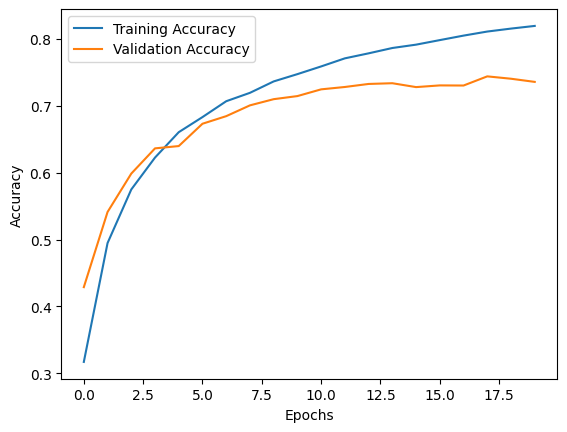

In [180]:
train_acc_cnn = training_history.history['accuracy']
val_acc_cnn = training_history.history['val_accuracy']

# Training sample accuracy curve
plt.plot(train_acc_cnn, label='Training Accuracy')
# Test sample accuracy curve
plt.plot(val_acc_cnn, label='Validation Accuracy')
# Axis labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [181]:
test_pred = model.predict(X_test)
test_pred_class = test_pred.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)

#print(metrics.classification_report(y_test_class, test_pred_class))
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)

# Extracting mean values
mean_precision = report['weighted avg']['precision']
mean_recall = report['weighted avg']['recall']
mean_f1_score = report['weighted avg']['f1-score']

# Output the mean values
print(f'Mean Precision: {mean_precision:.2f}')
print(f'Mean Recall: {mean_recall:.2f}')
print(f'Mean F1-Score: {mean_f1_score:.2f}')

431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean Precision: 0.74
Mean Recall: 0.74
Mean F1-Score: 0.73


C:\Users\Besitzer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Besitzer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Besitzer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_cla

In [182]:
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)
print(cnf_matrix)

[[ 23   1   0 ...   0   0   0]
 [  0 221   0 ...   0   0   0]
 [  0   0   6 ...   0   0   0]
 ...
 [  0   0   0 ...  58   0   0]
 [  0   0   0 ...   1   6   0]
 [  0   0   0 ...   8   0   4]]


Excluding words with low samples improves the efficiency of the model significantly. Therefore, it seems to be a good idea to generate additional data for these words, especially those with low samples, using the ImageDataGenerator function to evaluate the model's performance without losing too many words from the dataset.

In [198]:
# Print transcription distribution before filtering
print("Transcription distribution before filtering:")
print(df['transcription'].value_counts())

# Remove transcriptions with fewer than 40 samples
min_samples = 40
class_counts = df['transcription'].value_counts()
classes_to_keep = class_counts[class_counts >= min_samples].index
df_filtered = df[df['transcription'].isin(classes_to_keep)].copy()

# Reset index after manipulation
df_filtered.reset_index(drop=True, inplace=True)

# Define the ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Loop through each transcription that has between 40 and 50 samples and apply augmentation
transcription_counts = df_filtered['transcription'].value_counts()
for transcription, count in transcription_counts.items():
    if 40 < count < 50:
        print(f"Augmenting images for transcription: '{transcription}'")

        # Get the rows corresponding to this transcription
        transcription_df = df_filtered[df_filtered['transcription'] == transcription]

        # Loop through the images and apply augmentation
        for _, row in transcription_df.iterrows():
            img_path = row['image_path']

            # Read the image
            img = cv2.imread(img_path)
            if img is None:
                continue

            img_array = np.expand_dims(img, axis=0)  # Reshape to match ImageDataGenerator's expected input

            # Generate augmented images
            i = 0
            save_dir = os.path.dirname(img_path)
            for batch in train_datagen.flow(img_array, batch_size=1, save_to_dir=save_dir, save_prefix='aug', save_format='png'):
                i += 1
                if i >= (50 - count):  # Generate enough images to reach 50 samples
                    break

print("Data augmentation completed.")

# Step to reload the augmented data into the DataFrame
augmented_data = []

# Add original data to the new DataFrame
augmented_data.extend(df_filtered.to_dict('records'))

# Iterate over filtered DataFrame to check for augmented images
for transcription in transcription_counts.index:
    transcription_folder = os.path.dirname(df_filtered[df_filtered['transcription'] == transcription].iloc[0]['image_path'])
    
    # Loop through the directory for augmented images
    for file_name in os.listdir(transcription_folder):
        if file_name.startswith('aug') and file_name.endswith(('.png', '.jpg', '.jpeg')):
            # Add augmented image details to augmented_data
            row = df_filtered[df_filtered['transcription'] == transcription].iloc[0]
            augmented_data.append({
                'line_id': row['line_id'],
                'result': row['result'],
                'graylevel': row['graylevel'],
                'x': row['x'],
                'y': row['y'],
                'w': row['w'],
                'h': row['h'],
                'annotation': row['annotation'],
                'transcription': row['transcription'],
                'image_path': os.path.join(transcription_folder, file_name)
            })

# Create a new DataFrame including augmented data
df_augmented = pd.DataFrame(augmented_data, columns=df_filtered.columns)

# Print transcription distribution after augmentation
print("\nTranscription distribution after augmentation:")
print(df_augmented['transcription'].value_counts())

# Compare the initial and updated counts
print("\nComparing initial and updated counts:")
for transcription in transcription_counts.index:
    initial_count = transcription_counts[transcription]
    updated_count = df_augmented['transcription'].value_counts().get(transcription, 0)
    if updated_count > initial_count:
        print(f"Transcription '{transcription}' was augmented from {initial_count} to {updated_count} samples.")

Transcription distribution before filtering:
transcription
the           5826
,             5570
.             4984
of            3192
to            2651
              ... 
dimensions       1
painting         1
cutters          1
Parana           1
hullo            1
Name: count, Length: 13550, dtype: int64
Augmenting images for transcription: 'Naples'
Augmenting images for transcription: 'Dr.'
Augmenting images for transcription: 'though'
Augmenting images for transcription: 'His'
Augmenting images for transcription: 'wrote'
Augmenting images for transcription: 'number'
Augmenting images for transcription: 'brought'
Augmenting images for transcription: 'country'
Augmenting images for transcription: 'night'
Augmenting images for transcription: ''re'
Augmenting images for transcription: 'while'
Augmenting images for transcription: 'eyes'
Augmenting images for transcription: 'four'
Augmenting images for transcription: 'Britain'
Augmenting images for transcription: 'For'
Augmenting images

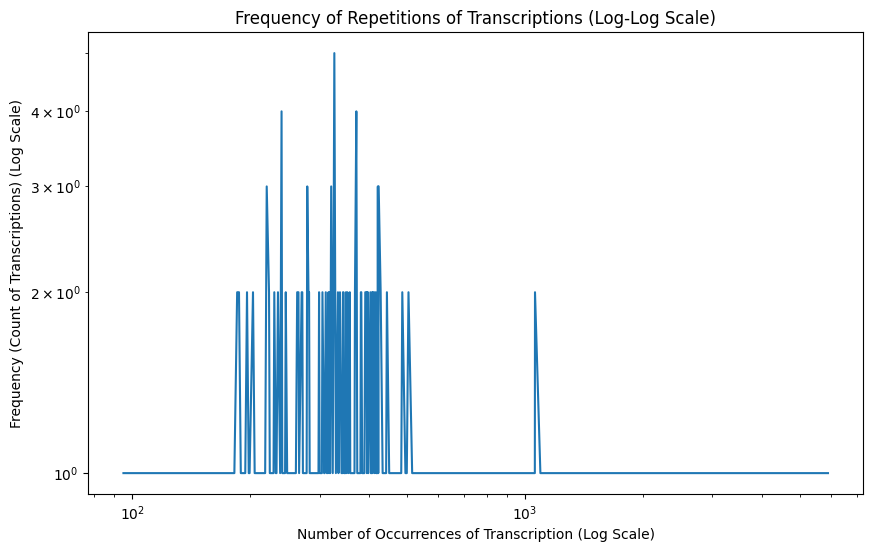

In [199]:
transcription_counts = df_augmented['transcription'].value_counts()
frequency_counts = transcription_counts.value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x=frequency_counts.index, y=frequency_counts.values)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Occurrences of Transcription (Log Scale)')
plt.ylabel('Frequency (Count of Transcriptions) (Log Scale)')
plt.title('Frequency of Repetitions of Transcriptions (Log-Log Scale)')
plt.show()

In [200]:
le = LabelEncoder()
df_augmented['transcription_encoded'] = None
df_augmented['transcription_encoded'] = le.fit_transform(df_augmented['transcription'])

In [201]:
X = []
y = []

# Use tqdm to add a progress bar
for index, row in tqdm(df_augmented.iterrows(), total=df_augmented.shape[0], desc="Processing Images"):
    # Save only images in X and transcription in Y, using cv2.imread to read the image without resizing or normalizing
    image = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
    if image is not None:
        X.append(image)
        y.append(row['transcription_encoded'])
    else:
        print(f"Warning: Image at path {row['image_path']} could not be read.")

print('X and Y have the same length:', len(X) == len(y))

Processing Images: 100%|██████████| 137140/137140 [35:30<00:00, 64.37it/s] 

X and Y have the same length: True


In [202]:
# X contains elements of varying shapes or sizes, meaning that not all images have the same dimensions, 
# we need to convert all element of X into a uniform dimension in order to ba able to convert them into Numpy array array
X_resized = []

for img in X:
    # If the image is not 28x28, resize it
    if img.shape != (28, 28):
        img = cv2.resize(img, (28, 28))
    X_resized.append(img)

# Convert to NumPy array after resizing
X = np.array(X_resized)
y = np.array(y)

#splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Changing the shape of X_train and X_test
X_train = X_train.reshape([-1, 28*28])
X_test = X_test.reshape([-1, 28*28])

# Transform the X_train and X_test data into a 4 dimensional array (nb_images, width, height, depth)
X_train = X_train.reshape((-1,28,28,1))
X_test = X_test.reshape((-1,28,28,1))
# Normalization of X_train and X_test
X_train = X_train/255
X_test = X_test/255

#Transform the labels of y_train and y_test into binary categorical vectors (one hot)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('Shape of y:',y_train.shape)


Shape of y: (109712, 287)


In [205]:
#Instantiate an input layer taking as argument shape = (28,28,1)
inputs = Input(shape = (28, 28,1), name = "Input")

# Instantiate a convolution layer called first_layer using the Conv2D constructor
first_layer = Conv2D(filters = 32,  #The layer will be composed of 32 convolution matrices.
                     kernel_size = (5, 5), #the convolution kernel will be of dimension 5x5 (25 neurons per filter).
                     padding = 'valid', #so that the kernel cannot exceed the edges of the image.  
                     activation = 'relu')
second_layer = MaxPooling2D(pool_size = (2, 2)) # Instantiate a max-pooling layer called second_layer using the MaxPooling2D constructor with the parameter pool_size = (2, 2) so that the maximum is computed on 2x2 size pieces.


# Add the layers to the model
x=first_layer(inputs)
x=second_layer(x)

# Instantiate a dropout layer called third_layer using the Dropout constructor with the rate = 0.2 parameter to cut off 20% of the connections between the previous and next layers.
third_layer = Dropout(rate = 0.2)
#  Instantiate a flattening layer called fourth_layer using the Flatten constructor. This layer does not take any parameters and just flattens a matrix into a vector. This transformation is necessary for the following because dense layers only take vectors as input and not matrices.
fourth_layer = Flatten()
#  Instantiate a dense layer called fifth_layer using the Dense constructor with 128 neurons and the ReLU activation function.
fifth_layer = Dense(units = 1024,
                    activation = 'relu')
sixth_layer = Dropout(rate = 0.2)
#  Instantiate a dense layer called output_layer with 10 neurons (for 10 output classes) and an activation function softmax to return probability predictions for each class.
output_layer = Dense(units = 287,
                     activation='softmax')
# Add all new layers to the model
x=third_layer(x)
x=fourth_layer(x)
x=fifth_layer(x)
x=sixth_layer(x)
outputs=output_layer(x)


# Create the Model
model = Model(inputs = inputs, outputs = outputs)

#Compile the model using the 'categorical_crossentropy' loss function, the 'adam' gradient descent algorithm as optimizer', and the **['accuracy']`** metric.
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

#Train the model with the training data on 10 epochs, batches of size 200 and a test split of 0.2. Store the training output in a variable named training_history.
training_history = model.fit(X_train,y_train,validation_split=0.2,epochs=20,batch_size=200)

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.1551 - loss: 4.7777 - val_accuracy: 0.2812 - val_loss: 3.7846
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.2907 - loss: 3.6729 - val_accuracy: 0.3184 - val_loss: 3.4452
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.3354 - loss: 3.2887 - val_accuracy: 0.3488 - val_loss: 3.1969
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.3664 - loss: 2.9888 - val_accuracy: 0.3655 - val_loss: 3.0062
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - accuracy: 0.3952 - loss: 2.7226 - val_accuracy: 0.3738 - val_loss: 2.8649
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.4198 - loss: 2.4960 - val_accuracy: 0.3806 - val_loss: 2.7547
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - accuracy: 0.4422 - loss: 2.3016 - val_accuracy: 0.3875 - val_loss: 2.6678
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.4587 - loss: 2.1463 - 

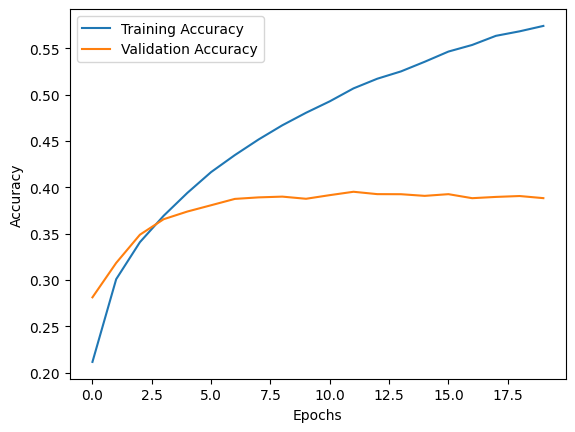

In [206]:
train_acc_cnn = training_history.history['accuracy']
val_acc_cnn = training_history.history['val_accuracy']

# Training sample accuracy curve
plt.plot(train_acc_cnn, label='Training Accuracy')
# Test sample accuracy curve
plt.plot(val_acc_cnn, label='Validation Accuracy')
# Axis labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Now let us compare these results to the ones without augmenting data, o check if there is a real improvement.

In [209]:
print("Transcription distribution before filtering:")
print(df['transcription'].value_counts())

# Remove transcription with fewer than 40 samples
min_samples = 40
class_counts = df['transcription'].value_counts()
classes_to_keep = class_counts[class_counts >= min_samples].index
df_filtered = df[df['transcription'].isin(classes_to_keep)].copy()
# reset index after manipulation
df_filtered.reset_index(drop=True, inplace=True)

print("Transcription distribution after filtering:")
print(df_filtered['transcription'].value_counts())

Transcription distribution before filtering:
transcription
the           5826
,             5570
.             4984
of            3192
to            2651
              ... 
dimensions       1
painting         1
cutters          1
Parana           1
hullo            1
Name: count, Length: 13550, dtype: int64
Transcription distribution after filtering:
transcription
the      5826
,        5570
.        4984
of       3192
to       2651
         ... 
best       40
While      40
both       40
case       40
early      40
Name: count, Length: 287, dtype: int64


In [210]:
le = LabelEncoder()
df_filtered['transcription_encoded'] = None
df_filtered['transcription_encoded'] = le.fit_transform(df_filtered['transcription'])

X = []
y = []

# Use tqdm to add a progress bar
for index, row in tqdm(df_filtered.iterrows(), total=df_filtered.shape[0], desc="Processing Images"):
    # Save only images in X and transcription in Y, using cv2.imread to read the image without resizing or normalizing
    image = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
    if image is not None:
        X.append(image)
        y.append(row['transcription_encoded'])
    else:
        print(f"Warning: Image at path {row['image_path']} could not be read.")

print('X and Y have the same length:', len(X) == len(y))

Processing Images: 100%|██████████| 72017/72017 [00:25<00:00, 2793.48it/s]

X and Y have the same length: True


In [211]:
# X contains elements of varying shapes or sizes, meaning that not all images have the same dimensions, 
# we need to convert all element of X into a uniform dimension in order to ba able to convert them into Numpy array array
X_resized = []

for img in X:
    # If the image is not 28x28, resize it
    if img.shape != (28, 28):
        img = cv2.resize(img, (28, 28))
    X_resized.append(img)

# Convert to NumPy array after resizing
X = np.array(X_resized)
y = np.array(y)

#splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Changing the shape of X_train and X_test
X_train = X_train.reshape([-1, 28*28])
X_test = X_test.reshape([-1, 28*28])

# Transform the X_train and X_test data into a 4 dimensional array (nb_images, width, height, depth)
X_train = X_train.reshape((-1,28,28,1))
X_test = X_test.reshape((-1,28,28,1))
# Normalization of X_train and X_test
X_train = X_train/255
X_test = X_test/255

#Transform the labels of y_train and y_test into binary categorical vectors (one hot)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('Shape of y:',y_train.shape)

#Instantiate an input layer taking as argument shape = (28,28,1)
inputs = Input(shape = (28, 28,1), name = "Input")

# Instantiate a convolution layer called first_layer using the Conv2D constructor
first_layer = Conv2D(filters = 32,  #The layer will be composed of 32 convolution matrices.
                     kernel_size = (5, 5), #the convolution kernel will be of dimension 5x5 (25 neurons per filter).
                     padding = 'valid', #so that the kernel cannot exceed the edges of the image.  
                     activation = 'relu')
second_layer = MaxPooling2D(pool_size = (2, 2)) # Instantiate a max-pooling layer called second_layer using the MaxPooling2D constructor with the parameter pool_size = (2, 2) so that the maximum is computed on 2x2 size pieces.


# Add the layers to the model
x=first_layer(inputs)
x=second_layer(x)

# Instantiate a dropout layer called third_layer using the Dropout constructor with the rate = 0.2 parameter to cut off 20% of the connections between the previous and next layers.
third_layer = Dropout(rate = 0.2)
#  Instantiate a flattening layer called fourth_layer using the Flatten constructor. This layer does not take any parameters and just flattens a matrix into a vector. This transformation is necessary for the following because dense layers only take vectors as input and not matrices.
fourth_layer = Flatten()
#  Instantiate a dense layer called fifth_layer using the Dense constructor with 128 neurons and the ReLU activation function.
fifth_layer = Dense(units = 1024,
                    activation = 'relu')
sixth_layer = Dropout(rate = 0.2)
#  Instantiate a dense layer called output_layer with 10 neurons (for 10 output classes) and an activation function softmax to return probability predictions for each class.
output_layer = Dense(units = 287,
                     activation='softmax')
# Add all new layers to the model
x=third_layer(x)
x=fourth_layer(x)
x=fifth_layer(x)
x=sixth_layer(x)
outputs=output_layer(x)


# Create the Model
model = Model(inputs = inputs, outputs = outputs)

#Compile the model using the 'categorical_crossentropy' loss function, the 'adam' gradient descent algorithm as optimizer', and the **['accuracy']`** metric.
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

#Train the model with the training data on 10 epochs, batches of size 200 and a test split of 0.2. Store the training output in a variable named training_history.
training_history_original = model.fit(X_train,y_train,validation_split=0.2,epochs=20,batch_size=200)



Shape of y: (57613, 287)
Epoch 1/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.2784 - loss: 3.8767 - val_accuracy: 0.5276 - val_loss: 2.1541
Epoch 2/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.5433 - loss: 2.0317 - val_accuracy: 0.6180 - val_loss: 1.6267
Epoch 3/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.6392 - loss: 1.5324 - val_accuracy: 0.6772 - val_loss: 1.3831
Epoch 4/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.6954 - loss: 1.2477 - val_accuracy: 0.6975 - val_loss: 1.2542
Epoch 5/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.7389 - loss: 1.0659 - val_accuracy: 0.7222 - val_loss: 1.1607
Epoch 6/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.7693 - loss: 0.9286 - val_accuracy: 0.7343 - val_loss: 1.1103
Epoch 7/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.8010 - loss: 0.8075 - val_accuracy: 0.7509 - val_loss: 1.0519
Epoch 8/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy:

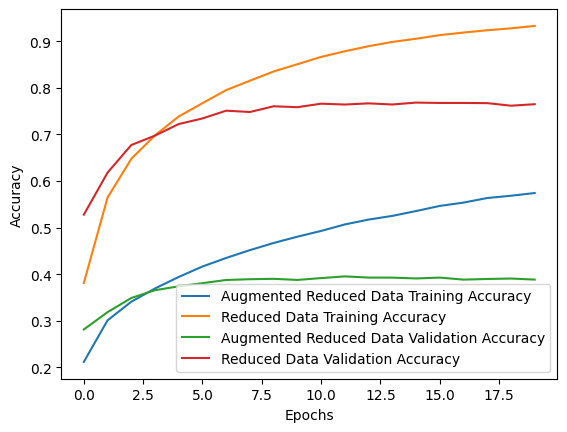

In [213]:
train_acc_cnn = training_history.history['accuracy']
val_acc_cnn = training_history.history['val_accuracy']

train_acc_cnn2 = training_history_original.history['accuracy']
val_acc_cnn2 = training_history_original.history['val_accuracy']

# Training sample accuracy curve
plt.plot(train_acc_cnn, label='Augmented Reduced Data Training Accuracy')
plt.plot(train_acc_cnn2, label='Reduced Data Training Accuracy')

# Test sample accuracy curve
plt.plot(val_acc_cnn, label='Augmented Reduced Data Validation Accuracy')
plt.plot(val_acc_cnn2, label='Reduced Data Validation Accuracy')

# Axis labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()